## Upload and config the image

In [1]:
# For uploading files
from google.colab import files
uploaded = files.upload()

Saving anh.jpg to anh.jpg


In [2]:
IMAGE_FILE = "anh.jpg"

## Visualize the image

In [3]:
import matplotlib.pyplot as plt

def show_image(image, title=None):
  if isinstance(image, str):
    image = plt.imread(image)

  height, width, _ = image.shape
  print(f"Size of image: {width} x {height} - {height * width} pixels")

  plt.imshow(image)
  plt.axis('off')
  plt.title(title, fontweight ="bold")
  plt.show()

Size of image: 256 x 256 - 65536 pixels


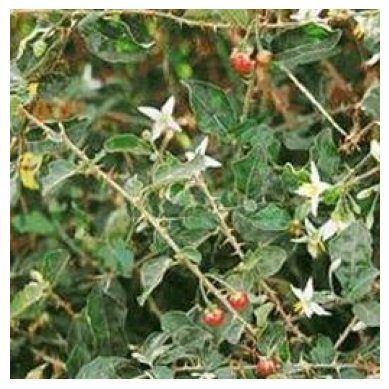

In [4]:
show_image(IMAGE_FILE)

## Gaussian Blur Filter Matrix

In [11]:
import math
import numpy as np

def gaussian_blur_filter_matrix(filter_size=7, sigma=3):
  mean = filter_size // 2
  matrix = []
  for _ in range(filter_size):
    matrix.append([0]*filter_size)

  sum = 0.0
  for x in range(filter_size):
    for y in range(filter_size):
      matrix[y][x] = math.exp(-((x - mean)**2 + (y - mean)**2)/(2*sigma**2)) / (2*math.pi*sigma**2)
      sum += matrix[y][x]

  for x in range(filter_size):
    for y in range(filter_size):
      matrix[y][x] /= sum

  return matrix


def default_blur_filter_matrix():
  matrix = np.array([
      [0, 0, 1, 2, 1, 0, 0],
      [0, 3, 13, 22, 13, 3, 0],
      [1, 13, 59, 97, 59, 13, 1],
      [2, 22, 97, 159, 97, 22, 2],
      [1, 13, 59, 97, 59, 13, 1],
      [0, 3, 13, 22, 13, 3, 0],
      [0, 0, 1, 2, 1, 0, 0],
  ])
  return matrix / 1003

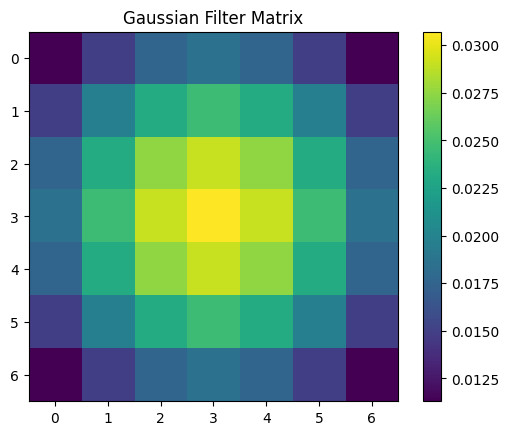

In [12]:
guassian_filter = gaussian_blur_filter_matrix(7)

import matplotlib.pyplot as plt

plt.imshow(guassian_filter)
plt.title('Gaussian Filter Matrix')
plt.colorbar()
plt.show()

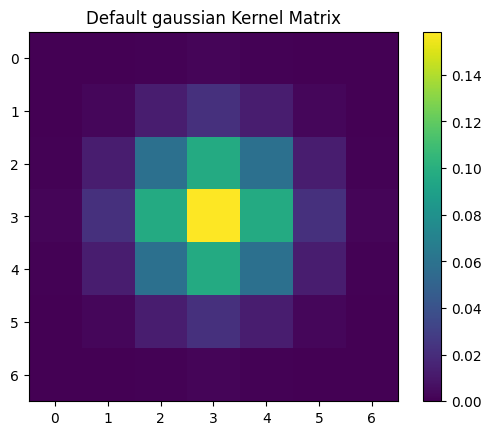

In [13]:
import matplotlib.pyplot as plt

plt.imshow(default_blur_filter_matrix())
plt.title('Default gaussian filter Matrix')
plt.colorbar()
plt.show()

## Grayscale CPU implementation

In [43]:
import numpy as np
import time

def gaussian_blur_cpu(image_file, filter_size=7):
  img = plt.imread(IMAGE_FILE)
  out = np.zeros(img.shape, np.uint8)

  height, width, _ = img.shape
  print(height, width)

  # get filter first
  # filter = gaussian_blur_filter_matrix(filter_size)
  filter = default_blur_filter_matrix()
  half_filter_size = filter_size // 2

  # start doing blur image
  start_t = time.time()
  print(f"Do blur image by cpu ...")

  for row_idx in range(height):
    for col_idx in range(width):
      # do convo
      cell = [0]*3
      for i in range(filter_size):
        for j in range(filter_size):
          if i+row_idx-half_filter_size >= height or i+row_idx-half_filter_size < 0 \
              or j+col_idx-half_filter_size >= width or j+col_idx-half_filter_size < 0:
            continue

          for channel in range(3):
            cell[channel] += filter[i][j] * img[i+row_idx-half_filter_size][j+col_idx-half_filter_size][channel]
      out[row_idx][col_idx] = [int(cell[0]), int(cell[1]), int(cell[2])]

  total_time = time.time() - start_t
  print(f"It took {total_time} s to finish.")
  return out, total_time

blur_img, _ = gaussian_blur_cpu(IMAGE_FILE)

256 256
Do blur image by cpu ...
It took 12.338244438171387 s to finish.


Size of image: 256 x 256 - 65536 pixels


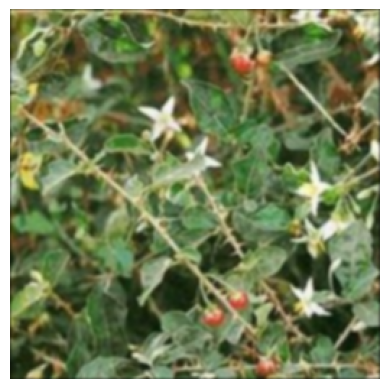

In [44]:
show_image(blur_img)

## Grayscale GPU implementation

In [30]:
from numba import cuda
import numpy as np
import time

@cuda.jit
def gaussian_blur(src, dst, filter, xSize, ySize):
  tidx = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
  tidy = cuda.threadIdx.y + cuda.blockIdx.y * cuda.blockDim.y

  filter_size = len(filter)
  half_filter_size = filter_size // 2

  # do convo
  r, g, b = 0, 0, 0
  for i in range(filter_size):
    for j in range(filter_size):
      if i+tidx-half_filter_size >= xSize or i+tidx-half_filter_size < 0 or \
          j+tidy-half_filter_size >= ySize or j+tidy-half_filter_size < 0:
        continue
      r += filter[i][j] * src[i+tidx-half_filter_size][j+tidy-half_filter_size][0]
      g += filter[i][j] * src[i+tidx-half_filter_size][j+tidy-half_filter_size][1]
      b += filter[i][j] * src[i+tidx-half_filter_size][j+tidy-half_filter_size][2]

  dst[tidx, tidy, 0] = np.uint8(r)
  dst[tidx, tidy, 1] = np.uint8(g)
  dst[tidx, tidy, 2] = np.uint8(b)


def gaussian_blur_gpu_2d(image_file, blockSize=(32, 32)):
  img = plt.imread(image_file)
  imageHeight, imageWidth, _ = img.shape
  gridSize = (
    (imageHeight + blockSize[0] - 1) // blockSize[0],
    (imageWidth + blockSize[1] - 1) // blockSize[1]
  )

  filter_matrix = default_blur_filter_matrix()
  # filter_matrix = gaussian_blur_filter_matrix(filter_size=6, sigma=3)

  print(f"Do blur image by gpu, blockSize={blockSize} ...")

  start_t = time.time()

  devSrc = cuda.to_device(img)
  devDst = cuda.device_array((imageHeight, imageWidth, 3), np.uint8)
  filter_gpu = cuda.to_device(filter_matrix)
  gaussian_blur[gridSize, blockSize](devSrc, devDst, filter_gpu, imageHeight, imageWidth)
  img = devDst.copy_to_host()

  total_time = time.time() - start_t
  print(f"It took {total_time} seconds to finish.")

  return img, total_time


Do blur image by gpu, blockSize=(32, 32) ...
It took 0.007427215576171875 seconds to finish.
Size of image: 256 x 256 - 65536 pixels


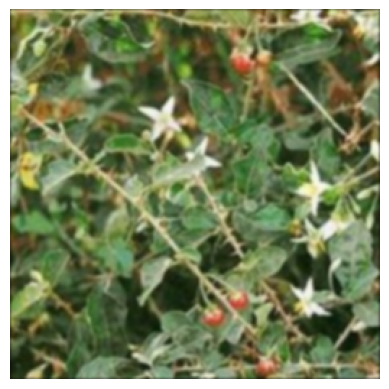

In [32]:
blur_img, _ = gaussian_blur_gpu_2d(IMAGE_FILE, (32, 32))

show_image(blur_img)

## Experiment with diﬀerent 2D block size values

Do blur image by gpu, blockSize=(8, 8) ...
It took 0.45337772369384766 seconds to finish.
Do blur image by gpu, blockSize=(8, 8) ...
It took 0.002310514450073242 seconds to finish.
Do blur image by gpu, blockSize=(16, 16) ...
It took 0.002209901809692383 seconds to finish.
Do blur image by gpu, blockSize=(32, 32) ...
It took 0.0028955936431884766 seconds to finish.


/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


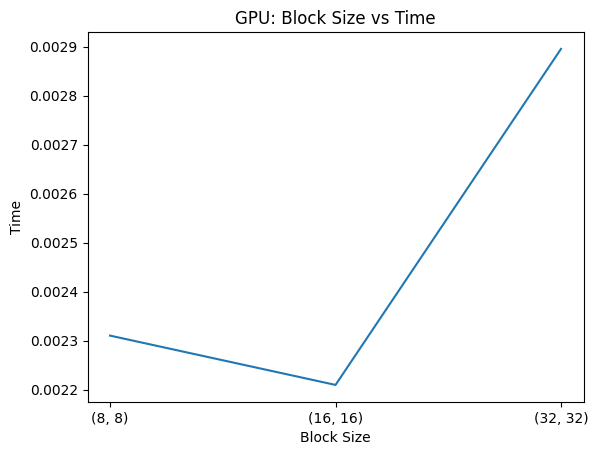

In [25]:
import matplotlib.pyplot as plt

# Process in 2D grid
block_sizes = [
   (8, 8), (8, 8), (16, 16), (32, 32),
]

process_times = []
img = None
for block_size in block_sizes:
  img, total_time = gaussian_blur_gpu_2d(IMAGE_FILE, block_size)
  process_times.append(total_time)

# Plot a graph of block size vs time
x_labels = [str(dim) for dim in block_sizes]
plt.plot(x_labels[1:], process_times[1:])

plt.title('GPU: Block Size vs Time')
plt.xlabel('Block Size')
plt.ylabel('Time')
plt.show()
